In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/X_train.csv').iloc[:, :4099]

In [3]:
data.drop(['Unnamed: 0', 'age', 'gender'], axis=1, inplace=True)
print(data.shape)

(659, 4096)


In [4]:
data.head()

,i_0,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,...,i_4086,i_4087,i_4088,i_4089,i_4090,i_4091,i_4092,i_4093,i_4094,i_4095
0,-59.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,-58.0,...,39.0,4.0,-9.0,-14.0,-19.0,-19.0,24.0,24.0,-14.0,-19.0
1,-39.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-38.0,-35.0,-27.0,...,-94.0,-97.0,-98.0,-98.0,-98.0,-98.0,-98.0,-98.0,-98.0,-98.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,-82.0,-79.0,-73.0,-65.0,-57.0,-56.0,-59.0,-63.0,-68.0,-71.0
3,108.0,106.0,93.0,79.0,86.0,74.0,64.0,51.0,41.0,47.0,...,-109.0,-98.0,-91.0,-83.0,-74.0,-67.0,-56.0,-51.0,-44.0,-36.0
4,363.0,366.0,366.0,353.0,334.0,314.0,306.0,294.0,303.0,299.0,...,-117.0,-112.0,-114.0,-76.0,-79.0,-82.0,-99.0,-112.0,-101.0,-107.0


In [5]:
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [16]:
import keras.backend as K

def Conv1DTranspose(filters, strides, kernel_size=20, activation='relu', data_format='channels_last', padding='same'):
    x = Sequential()
    x.add(Lambda(lambda x: K.expand_dims(x, axis=2)))
    x.add(Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1),
                          activation=activation, padding=padding))
    x.add(Lambda(lambda x: K.squeeze(x, axis=2)))
    return x

In [22]:
def build_g():
    """
      Input: [None, 100]
      Output: [None, 4096, 1]
    """
    generator = Sequential()

    # FC and reshape for convolution
    # [100] -> [16, 1024]
    generator.add(Dense(4096, input_dim=100, activation='relu'))
    generator.add(Reshape((16, 256,)))
    generator.add(BatchNormalization())

    # [16, 256] -> [128, 512]
    generator.add(Conv1DTranspose(filters=512, strides=8))
    generator.add(BatchNormalization())

    # [128, 512] -> [512, 256]
    generator.add(Conv1DTranspose(filters=256, strides=4))
    generator.add(BatchNormalization())

    # [512, 256] -> [1024, 128]
    generator.add(Conv1DTranspose(filters=128, strides=2))
    generator.add(BatchNormalization())

     # [1024, 128] -> [2048, 64]
    generator.add(Conv1DTranspose(filters=64, strides=2))
    generator.add(BatchNormalization())

    # [2048, 64] -> [4096, 1]
    generator.add(Conv1DTranspose(filters=1, strides=2, activation='tanh'))
    
#     generator.summary()
    
    noise = Input(shape=(100,))
    ecg = generator(noise)
    
    return Model(noise, ecg)

In [23]:
def build_d():
    """
      Input: [None, 4096, 1]
      Output: [None] (linear output)
    """
    discriminator = Sequential()

    # [4096, 1] -> [2048, 64]
    discriminator.add(Conv1D(filters=64, kernel_size=(25,), strides=(2,), activation='relu', padding='same'))

    # [2048, 64] -> [1024, 128]
    discriminator.add(Conv1D(filters=128, kernel_size=(25,), strides=(2,), activation='relu', padding='same'))
    discriminator.add(BatchNormalization())

    # [1024, 128] -> [512, 256]
    discriminator.add(Conv1D(filters=256, kernel_size=(25,), strides=(2,), activation='relu', padding='same'))
    discriminator.add(BatchNormalization())

    # [512, 256] -> [128, 512]
    discriminator.add(Conv1D(filters=512, kernel_size=(25,), strides=(4,), activation='relu', padding='same'))
    discriminator.add(BatchNormalization())

    # [128, 512] -> [16, 256]
    discriminator.add(Conv1D(filters=256, kernel_size=(25,), strides=(8,), activation='relu', padding='same'))
    discriminator.add(BatchNormalization())

    # Flatten
    discriminator.add(Flatten())

    # Connect to single logit
    discriminator.add(Dense(1, activation='sigmoid'))
    
    ecg = Input(shape=(4096, 1,))
    validity = discriminator(ecg)
    
    return Model(ecg, validity)

In [24]:
optimizer = Adam(0.0002, 0.5)

dis = build_d()
dis.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gen = build_g()

noise = Input(shape=(100,))
ecg = gen(noise)

dis.trainable = False
validity = dis(ecg)

gan = Model(noise, validity)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [25]:
from tqdm import tqdm

batch_size = 32

d_losses, g_losses = [], []

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in tqdm(range(200)):
    idx = np.random.randint(0, data.shape[0], batch_size)
    ecgs = np.reshape(data.iloc[idx].values, (batch_size, data.shape[1], 1))
    
    noise = np.random.normal(-1, 1, (batch_size, 100))
    
    gen_ecgs = gen.predict(noise)
    
    d_loss_real = dis.train_on_batch(ecgs, valid)
    d_loss_fake = dis.train_on_batch(gen_ecgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(-1, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, valid)
    
    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\happy\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 200/200 [01:21<00:00,  3.02it/s]


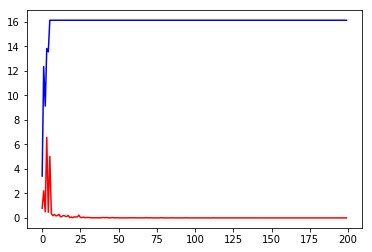

In [26]:
plt.plot(d_losses, 'r')
plt.plot(g_losses, 'b')
plt.show()

In [132]:
print(d_losses)

[0.34408057, 0.3342888, 0.44870463, 0.6318503, 0.45458287, 0.36189386, 0.3243562, 0.30328783, 0.32357174, 0.41300014]
